# Datavalanche

## Exploratory data analysis of the SLF deadly avalanche dataset

In [133]:
%load_ext autoreload
%autoreload 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import date
import folium
from folium import plugins
%aimport helpers
import pygrib

In [2]:
grbs = pygrib.open('testdata.grb')

In [4]:
print(grbs[1])

1:Snow density:kg m**-3 (instant):regular_ll:surface:level 0:fcst time 3 hrs:from 201202010000


In [7]:
t = grbs[1]

In [37]:
t['parameterName']

'Snow density'

In [52]:
t.latlons()[0].size

50

In [98]:
grbs[54].validDate

datetime.datetime(2012, 2, 1, 12, 0)

In [94]:
x.hour

0

In [91]:
t.analDate

datetime.datetime(2012, 2, 1, 0, 0)

In [56]:
x = []
h = "h" in x 
x.

False

In [27]:
snow_layer = grbs.select(name='Temperature of snow layer')

In [148]:
grbs[1].latlons()[0].size

50

In [176]:
df = helpers.grib_to_dataframe(grbs, 22)
df

,Date,Latitude,Longitude,Snow density,Soil temperature level 1,Snow depth,10 metre U wind component,10 metre V wind component,2 metre temperature,2 metre dewpoint temperature,Soil temperature level 2,Soil temperature level 3,Soil temperature level 4,Temperature of snow layer
0,2012-02-01 00:00:00,48,4.5,144.885,273.286,0.00182314,-2.62395,-2.60624,268.734,264.558,274.765,277.845,281.11,265.245
1,2012-02-01 00:00:00,48,5.25,154.913,272.833,0.00212304,-2.96453,-2.9545,268.485,263.28,274.424,277.48,280.615,263.181
2,2012-02-01 00:00:00,48,6,145.639,272.207,0.00157247,-3.1729,-3.21573,268.213,262.485,274.072,277.091,280.064,264.422
3,2012-02-01 00:00:00,48,6.75,149.151,271.663,0.00126536,-2.88445,-2.91569,267.958,261.895,273.922,276.726,279.531,264.41
4,2012-02-01 00:00:00,48,7.5,151.635,271.417,0.00196801,-2.37896,-2.95926,267.748,261.73,273.898,276.604,279.322,263.754
5,2012-02-01 00:00:00,48,8.25,155.545,271.265,0.0144172,-2.02325,-2.8173,267.445,261.943,274.094,276.459,279.095,263.453
6,2012-02-01 00:00:00,48,9,156.627,270.81,0.030444,-1.89642,-2.46818,266.762,262.281,274.107,276.145,278.708,261.155
7,2012-02-01 00:00:00,48,9.75,175.624,270.376,0.0527587,-2.0938,-1.89701,265.207,262.066,273.921,275.8,278.233,258.1
8,2012-02-01 00:00:00,48,10.5,280.471,271.472,0.100793,-2.80059,-1.0817,261.683,259.609,274.029,276.028,278.075,261.164
9,2012-02-01 00:00:00,48,11.25,291.592,272.498,0.107079,-3.19415,0.00264931,261.118,258.885,274.161,276.289,278.086,261.384


In [124]:
df

,Date,Latitude,Longitude,Snow density,Soil temperature level 1,Snow depth,10 metre U wind component,10 metre V wind component,2 metre temperature,2 metre dewpoint temperature,Soil temperature level 2,Soil temperature level 3,Soil temperature level 4,Temperature of snow layer
1,NaN,NaN,NaN,144.885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2012-02-01 00:00:00,48,4.5,154.913,273.286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2012-02-01 00:00:00,48,4.5,145.639,272.833,0.00182314,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012-02-01 00:00:00,48,4.5,149.151,272.207,0.00212304,-2.62395,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2012-02-01 00:00:00,48,4.5,151.635,271.663,0.00157247,-2.96453,-2.60624,NaN,NaN,NaN,NaN,NaN,NaN
6,2012-02-01 00:00:00,48,4.5,155.545,271.417,0.00126536,-3.1729,-2.9545,268.734,NaN,NaN,NaN,NaN,NaN
7,2012-02-01 00:00:00,48,4.5,156.627,271.265,0.00196801,-2.88445,-3.21573,268.485,264.558,NaN,NaN,NaN,NaN
8,2012-02-01 00:00:00,48,4.5,175.624,270.81,0.0144172,-2.37896,-2.91569,268.213,263.28,274.765,NaN,NaN,NaN
9,2012-02-01 00:00:00,48,4.5,280.471,270.376,0.030444,-2.02325,-2.95926,267.958,262.485,274.424,277.845,NaN,NaN
10,2012-02-01 00:00:00,48,4.5,291.592,271.472,0.0527587,-1.89642,-2.8173,267.748,261.895,274.072,277.48,281.11,NaN


In [119]:
len(grbs[1].data()[0].flatten())

50

In [74]:
len(range(1, int(nbPoints*grbs.messages/11) + 1))

11600

In [68]:
["Date", "Longitude", "Latitude"] + parameters

['Date',
 'Longitude',
 'Latitude',
 'Snow density',
 'Soil temperature level 1',
 'Snow depth',
 '10 metre U wind component',
 '10 metre V wind component',
 '2 metre temperature',
 '2 metre dewpoint temperature',
 'Soil temperature level 2',
 'Soil temperature level 3',
 'Soil temperature level 4',
 'Temperature of snow layer']

In [30]:
grbs.select(name="Snow density")[0]

1:Snow density:kg m**-3 (instant):regular_ll:surface:level 0:fcst time 3 hrs:from 201202010000

In [15]:
snow_layer[1].values

array([[ 265.06513977,  262.73603821,  263.49043274,  263.25508118,
         262.21601868,  261.45722961,  257.68525696,  253.11152649,
         258.76875305,  259.15107727],
       [ 262.47236633,  263.92451477,  263.92451477,  263.62812805,
         263.54023743,  265.28633118,  265.97773743,  264.73799133,
         262.8561554 ,  262.11787415],
       [ 265.16621399,  265.5983429 ,  262.9889679 ,  259.16572571,
         263.48408508,  262.6920929 ,  261.04804993,  260.56904602,
         261.4523468 ,  261.56465149],
       [ 266.81562805,  263.95527649,  261.5905304 ,  262.92158508,
         260.75508118,  255.10224915,  252.52412415,  256.46846008,
         265.09394836,  266.33174133],
       [ 266.38887024,  263.71455383,  262.12861633,  261.66181946,
         257.41719055,  255.32783508,  255.23457336,  260.22383118,
         267.60566711,  268.91816711]])

In [2]:
def parsedate(ts):
    return date.fromtimestamp(int(ts))

data = pd.read_csv('data/avalanches.csv', parse_dates=['date_posix_ts'], date_parser=parsedate)

In [3]:
data.head()

,winter,date_posix_ts,canton,community,starting_zone_Y,starting_zone_X,elevation,aspect_id,aspect_string,activity,victims,caught,buried,danger_level
0,2015/16,2016-07-04,VS,Baltschieder,631760,138570,3440,5,E,1,1,2,0,0
1,2015/16,2016-05-05,GR,Flims,737700,197340,2900,6,ESE,1,1,1,1,0
2,2015/16,2016-04-29,VS,Naters,640290,146390,3680,11,SW,1,1,2,1,2
3,2015/16,2016-04-20,GR,Sils im Engadin/Segl,781510,135430,2810,3,NE,1,1,1,1,3
4,2015/16,2016-04-19,VS,Orsières,570830,93228,3100,2,NNE,2,1,2,1,3


Let's see how many deadly avalanches occurred each year during the last 20 years

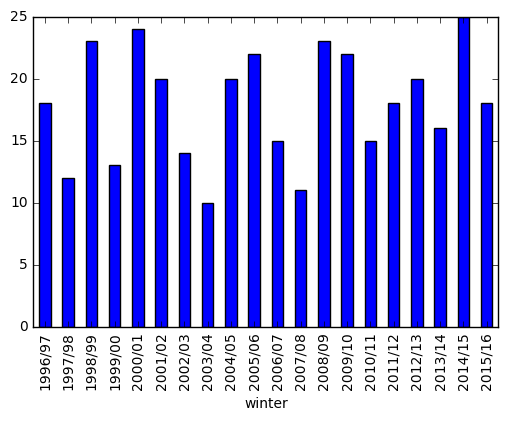

In [5]:
avalanches_per_winter = data.groupby('winter').count()['canton']
avalanches_per_winter.plot(kind='bar')

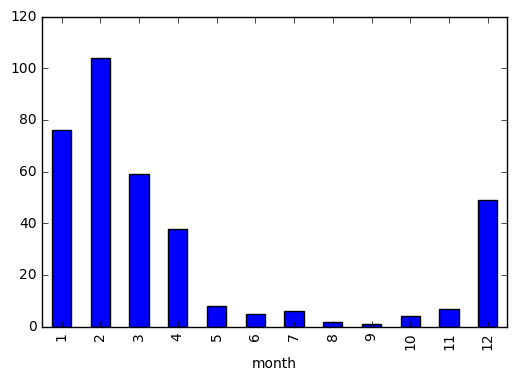

In [6]:
data['month'] = data['date_posix_ts'].map(lambda x: x.month)
avalanches_per_month = data.groupby('month').count()['canton']
avalanches_per_month.plot(kind='bar')

In [24]:
data.groupby(['winter', 'month']).count()['canton']

winter   month
1996/97  1         3
         2        12
         5         1
         7         1
         12        1
1997/98  1         5
         3         2
         4         1
         10        1
         12        3
1998/99  1         3
         2         9
         3         1
         4         2
         6         1
         7         1
         10        1
         12        5
1999/00  1         1
         2         4
         3         1
         4         2
         9         1
         11        1
         12        3
2000/01  1         4
         2        12
         3         3
         5         2
         6         1
                  ..
2011/12  2         6
         4         5
         12        5
2012/13  1         3
         2         6
         3         4
         4         3
         10        1
         11        1
         12        2
2013/14  1         2
         2         3
         3         1
         7         2
         8         1
         12        

TODO: we should try to compare this with data about total quantities of snow per year/month !


Let's now look at the aspect of the slopes where the avalanches occurred.

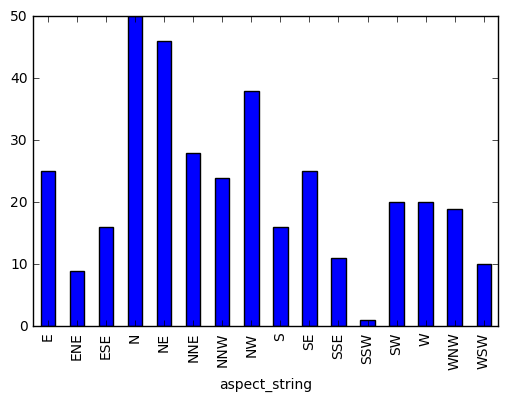

In [6]:
avalanches_per_aspect = data.groupby('aspect_string').count()['canton']
avalanches_per_aspect.plot(kind='bar')

It seems that north facing slopes are more dangerous. TODO: statistical test ?

Avalanches per danger level: TODO compare this with average proportion of days with given danger level during a winter (we should be abl to find this on the SLF website)

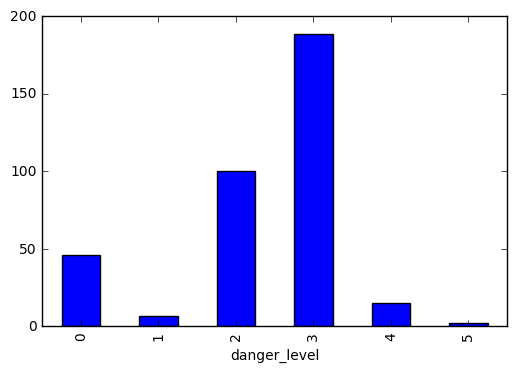

In [7]:
avalanches_per_danger = data.groupby('danger_level').count()['canton']
avalanches_per_danger.plot(kind='bar')

Let's see the distribution of avalanche starting point elevation

Mean avalanche start point elevation: 2519.9526462395543


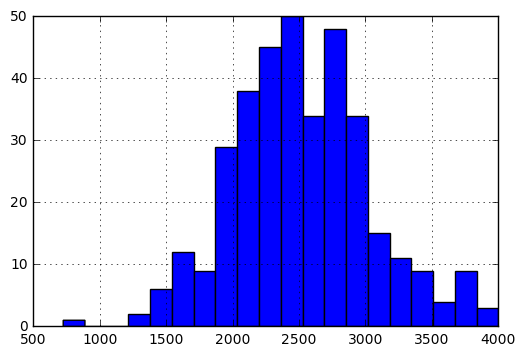

In [8]:
print('Mean avalanche start point elevation:', data['elevation'].mean())
data['elevation'].hist(bins=20)

Mean avalanche start point elevation: 2755.869918699187


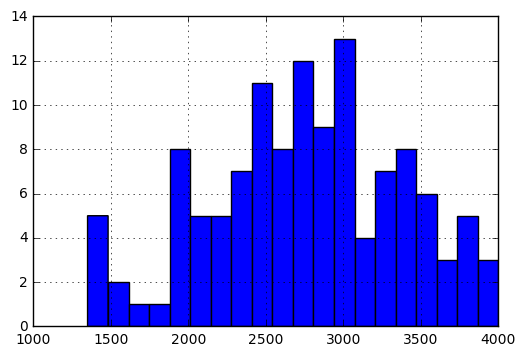

In [9]:
# TODO: maybe not so useful...
# Usually we don't go at high altitudes during the winter.
# Let's see if the mean altitude changes when not taking into account winter months
filtered_elevations = data[(data['month'] > 2) & (data['month'] < 11)]['elevation']
print('Mean avalanche start point elevation:', filtered_elevations.mean())
filtered_elevations.hist(bins=20)

# TODO: Some fancy map with avalanches per canton :D ?

In [10]:
# Get number of avalanches per canton
missing_cantons = ['ZH', 'ZG', 'SO', 'BS', 'BL', 'SH', 'JU', 'GE', 'NE','TG', 'AR', 'AG']
avalanches_per_canton = data.groupby('canton').count()[['winter']]
avalanches_per_canton.columns = [['count']]
avalanches_per_canton['count'] = avalanches_per_canton['count'].apply(lambda x: 0 if x == 0 else np.log10(x))
avalanches_per_canton = avalanches_per_canton.append(pd.DataFrame({'count':0}, index=missing_cantons))
avalanches_per_canton.reset_index(inplace=True)

In [11]:
topo_path = r'ch-cantons.topojson.json'
# Create map with log number of avalanches per canton 
av_per_canton_map = folium.Map(location=[46.8, 8.239], zoom_start=8)
av_per_canton_map.choropleth(geo_path = topo_path, data=avalanches_per_canton,
                     columns=['index', 'count'], 
                     key_on='feature.id',
                     fill_color='PuRd', fill_opacity=0.7, line_opacity=0.2,
                     topojson='objects.cantons')
av_per_canton_map

C:\Users\bapti\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: 'threshold_scale' default behavior has changed. Now you get a linear scale between the 'min' and the 'max' of your data. To get former behavior, use folium.utilities.split_six.


In [12]:
# Change the stupid coordinate system in latitude/longitude
for i in data.index:
    x = data.starting_zone_X[i]
    y = data.starting_zone_Y[i]
    lat = helpers.CHtoWGSlat(x, y)
    lng = helpers.CHtoWGSlng(x, y)
    data.set_value(i, 'lat', lat)
    data.set_value(i, 'lon', lng)
    
data.drop(['starting_zone_X','starting_zone_Y'], axis=1).head()

,winter,date_posix_ts,canton,community,elevation,aspect_id,aspect_string,activity,victims,caught,buried,danger_level,month,lat,lon
0,2015/16,2016-07-04,VS,Baltschieder,3440,5,E,1,1,2,0,0,7,46.397737,7.851589
1,2015/16,2016-05-05,GR,Flims,2900,6,ESE,1,1,1,1,0,5,46.912888,9.246352
2,2015/16,2016-04-29,VS,Naters,3680,11,SW,1,1,2,1,2,4,46.467623,7.963174
3,2015/16,2016-04-20,GR,Sils im Engadin/Segl,2810,3,NE,1,1,1,1,3,4,46.345707,9.796747
4,2015/16,2016-04-19,VS,Orsières,3100,2,NNE,2,1,2,1,3,4,45.989984,7.062188


In [13]:
# Count the number of avalanches per community
d2 = data[['community', 'lat', 'lon']]
cnt = d2.groupby('community').count()[['lat']]
cnt.columns = ['count']
avalanches_per_community = pd.concat([d2.groupby('community').first(), cnt], axis=1)
avalanches_per_community.head()

,lat,lon,count
community,,,
Adelboden,46.447069,7.511086,7
Aeschi bei Spiez,46.595959,7.768668,1
Airolo,46.565699,8.544159,1
Alt St Johann,47.200112,9.256064,1
Altstätten,47.287387,9.511861,1


In [25]:
# Create a heat_map of avalanches
avalanches_heat_map = folium.Map(location=[46.8, 8.239], zoom_start=8, tiles='Mapbox Bright', )
avalanches_heat_map.choropleth(geo_path = topo_path, topojson='objects.cantons', fill_opacity=0.3, line_opacity=0.7), 
avalanches_heat_map_vals = avalanches_per_community.as_matrix()
avalanches_heat_map.add_children(plugins.HeatMap(avalanches_heat_map_vals, radius = 20))

ten_most = avalanches_per_community.sort_values(by='count', ascending=False).head(10)
for index, row in ten_most.iterrows():
    location = [row['lat'], row['lon']]
    folium.Marker(location = location, popup=index, icon = folium.Icon(color ='red')).add_to(avalanches_heat_map)
    
heat_map

Idea:
 - Create a more interactive map with sliders to select year/month and buttons to chose what the heatmap is about: number of victims, buried etc..   